In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from tensorflow.contrib import predictor

/data/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import sys
sys.path.insert(0, '/Data/repos/zoobot')
from zoobot.tfrecord import catalog_to_tfrecord

### What's the Problem?

Given a galaxy image, we want to know if the galaxy is 'smooth' or featured.

We have a set of crowdsourced answers. Each galaxy has about 40 responses. 

Let's aim to predict the crowd majority vote.

### Look at the crowd labels

Load all crowd answers. How common is each response?

In [4]:
columns_to_save = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'smooth-or-featured_total-votes',
    'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_featured-or-disk_fraction',
    'smooth-or-featured_smooth_min',
    'smooth-or-featured_smooth_max',
    'smooth-or-featured_featured-or-disk_min',
    'smooth-or-featured_featured-or-disk_max',
    'smooth-or-featured_prediction-encoded',  # 0 for artifact, 1 for featured, 2 for smooth
    'classifications_count',
    'subject_id',
    'nsa_id',
    'ra',
    'dec']

df_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s28_l0.5_train.tfrecord.csv'
df = pd.read_csv(df_loc, usecols=columns_to_save + ['fits_loc', 'png_loc', 'png_ready'], dtype={'fits_loc': str})

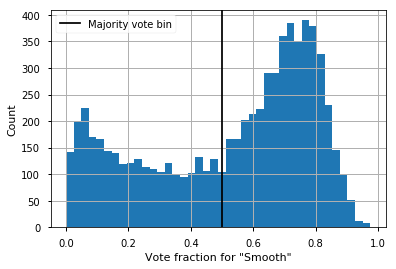

In [5]:
fraction_col = 'smooth-or-featured_smooth_fraction'
df['label'] = df[fraction_col] > 0.5
ax = df[fraction_col].hist(bins=40)
ax.axvline(0.5, c='k')
plt.xlabel('Vote fraction for "Smooth"')
plt.ylabel('Count')
plt.legend(['Majority vote bin'])

In [6]:
print(df['smooth-or-featured_prediction-encoded'].value_counts())
print(df[fraction_col].mean())

2    4651
1    2411
Name: smooth-or-featured_prediction-encoded, dtype: int64
0.5235302983992943


In [7]:
print(df['smooth-or-featured_smooth_fraction'].mean())
print(df['smooth-or-featured_featured-or-disk_fraction'].mean())

0.5235302983992943
0.3547887205672672


The crowd somewhat separates 'smooth' from 'featured' galaxies, but there's clearly a continuum. 

Let's start with the binary case (what would the majority say) and then move on to regression (what fraction would say 'smooth).

In [8]:
'Fraction of galaxies which the crowd thinks are smooth: {:.2f}%'.format(np.mean((df[fraction_col] < 0.5).astype(float)))

'Fraction of galaxies which the crowd thinks are smooth: 0.38%'

Smooth galaxies are a little less common than featured galaxies - bear this in mind when looking at accuracy. A dumb majority class classifier would get 60% accuracy.

### Train Bayesian CNN

See https://github.com/RustyPanda/zoobot/tree/master/zoobot

Training is done on .tfrecord files after a simple 80/20 train/test split.

### Load saved models at untrained, mid-training and trained stages

In [9]:
untrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526633289'  # needs update
midtrained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526636416' 
trained_model_loc = '/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526639533' 

untrained_model_unwrapped = predictor.from_saved_model(untrained_model_loc)
midtrained_model_unwrapped = predictor.from_saved_model(midtrained_model_loc)
trained_model_unwrapped = predictor.from_saved_model(trained_model_loc)

# wrap to avoid having to pass around dicts all the time
untrained_model = lambda x: 1 - untrained_model_unwrapped({'examples': x})['all_predictions']
midtrained_model = lambda x: 1 - midtrained_model_unwrapped({'examples': x})['all_predictions']
trained_model = lambda x: 1 - trained_model_unwrapped({'examples': x})['all_predictions']

models = [untrained_model, midtrained_model, trained_model]

INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526633289/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526636416/variables/variables'
INFO:tensorflow:Restoring parameters from b'/Data/repos/zoobot/zoobot/runs/bayesian_panoptes_featured_s64_l0.5_120k_test/1526639533/variables/variables'


## How accurate are the model samples on test data?

In [10]:
n_examples = 200
samples_per_example = 1000

### Load the the test catalog (galaxy labels)

In [11]:
train_df = pd.read_csv('/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_train.tfrecord.csv', usecols=[fraction_col])
train_data = train_df[:n_examples]  # index will match tfrecord examples

In [12]:
test_df = pd.read_csv('/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_test.tfrecord.csv', usecols=[fraction_col])
test_data = test_df[:n_examples]  # index will match tfrecord examples

### Load serialized galaxy examples

In [13]:
def load_examples_from_tfrecord(tfrecord_loc, n_examples):
    # see http://www.machinelearninguru.com/deep_learning/tensorflow/basics/tfrecord/tfrecord.html
    with tf.Session() as sess:
        # Create a list of filenames and pass it to a queue
        filename_queue = tf.train.string_input_producer([tfrecord_loc], num_epochs=1)
        # Define a reader and read the next record
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        # Initialize all global and local variables
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        # Create a coordinator and run all QueueRunner objects
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        # execute
        return [sess.run(serialized_example) for n in range(n_examples)]


In [14]:
tfrecord_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_train.tfrecord'
train_examples = load_examples_from_tfrecord(tfrecord_loc, n_examples)

In [15]:
tfrecord_loc = '/data/repos/zoobot/zoobot/data/panoptes_featured_s64_l0.5_test.tfrecord'
test_examples = load_examples_from_tfrecord(tfrecord_loc, n_examples)

Double check that these have genuinely different data:

In [16]:
print(len(train_examples))
print(len(test_examples))

200
200


In [17]:
train_examples[0] == test_examples[0]

False

In [18]:
print(train_examples[0][:10])
print(test_examples[0][:10])

b"\n\xda\x86\x03\n3\n'sm"
b'\n\xda\x86\x03\n\x0f\n\x03de'


Double check that tfrecord and data catalog indices align i.e. first example from tfrecord is first example in data catalog, etc.

In [19]:
def parse_example(example):
    with tf.Session() as sess:
        
            features = {
#                 'matrix': tf.FixedLenFeature([], tf.float32),
                'label': tf.FixedLenFeature([], tf.int64),
              }

            parsed_example = tf.parse_single_example(example, features=features)
            return sess.run(parsed_example)
            

In [20]:
train_record_labels = [parse_example(train_examples[n])['label'] for n in range(30)]
train_data_labels = (train_df[fraction_col] > 0.5).astype(int)[:30]

In [21]:
print(train_record_labels)
print(list(train_data_labels.values))
assert (train_record_labels == train_data_labels.values).all()

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]


### Make model predictions

In [25]:
def get_samples_of_examples(model, examples, samples_per_example):
    results_store = []
    for nth_run in range(int(samples_per_example / 10)):
        results_store.append(model(examples))
    return np.concatenate(results_store, axis=1)

In [26]:
all_model_results_train = np.array([get_samples_of_examples(model, train_examples, samples_per_example) for model in models])
# dimensions of [model, example, sample], values of sample
mean_model_results_train = np.mean(all_model_results_train, axis=2) # averaged over all samples
# dimensions of [model, example], values of mean sample

In [27]:
all_model_results_test = np.array([get_samples_of_examples(model, test_examples, samples_per_example) for model in models])
mean_model_results_test = np.mean(all_model_results_test, axis=2)

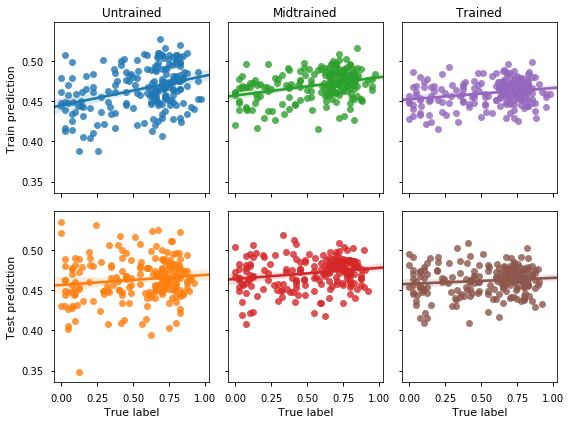

In [34]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 6))
for model_n in range(len(models)):
    sns.regplot(train_data[fraction_col], mean_model_results_train[model_n], ax=axes[0][model_n])
    sns.regplot(test_data[fraction_col], mean_model_results_test[model_n], ax=axes[1][model_n])
    axes[0][model_n].set_title(['Untrained', 'Midtrained', 'Trained'][model_n])
    axes[0][model_n].set_xlabel('')
    axes[1][model_n].set_xlabel('True label')
axes[0][0].set_ylabel('Train prediction')
axes[1][0].set_ylabel('Test prediction')
plt.tight_layout()

Not looking like great...

### What do the sample distributions of the trained model look like?

In [47]:
def are_labels_correct(results, fractions):
    correct_labels = fractions > 0.5
    predicted_labels = pd.Series(np.mean(results, axis=1)) > 0.5
    return correct_labels == predicted_labels

In [57]:
def view_samples(results, data):
    correct = are_labels_correct(results, data[fraction_col])
    fig, axes = plt.subplots(len(data), figsize=(4, len(data)), sharex=True, sharey=True)
    for galaxy_n, ax in enumerate(axes):
        ax.hist(results[galaxy_n, :])
        c='r'
        if correct[galaxy_n]:
            c='g'
        ax.axvline(data.iloc[galaxy_n][fraction_col], c=c)

#### Sample distributions on train data with untrained model

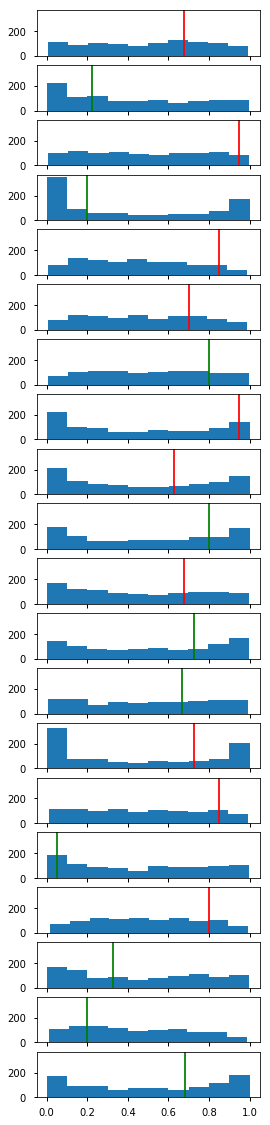

In [58]:
view_samples(all_model_results_train[0, :20, :], train_data[:20])

#### Sample distributions on train data with trained model

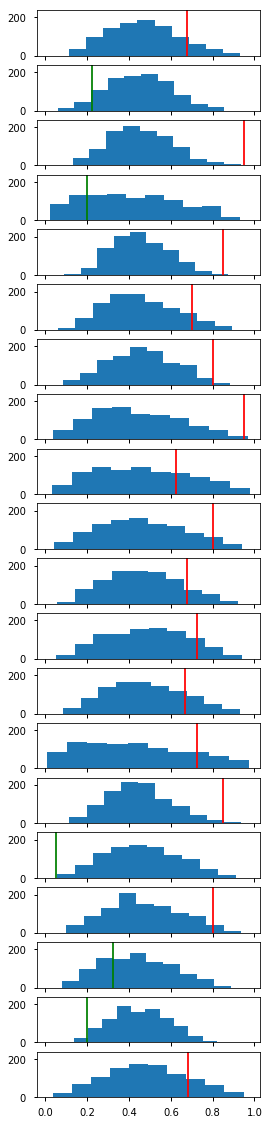

In [59]:
view_samples(all_model_results_train[2, :20, :], train_data[:20])

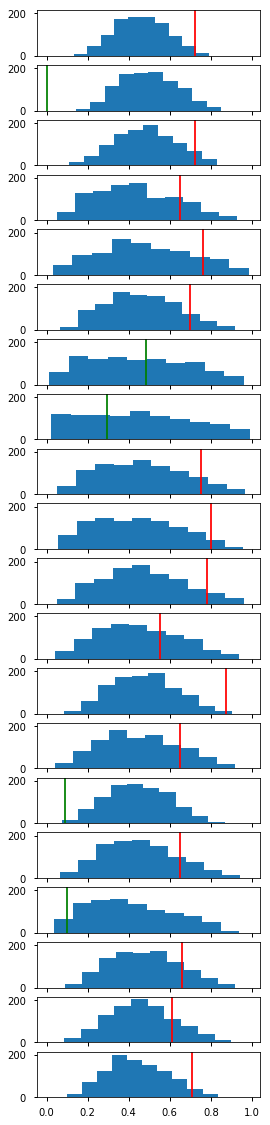

In [60]:
view_samples(all_model_results_test[2, :20, :], test_data[:20])

In [53]:
from scipy.stats import kurtosis

In [54]:
def get_kurtosis(model_results):
    return np.array([kurtosis(model_results[n, :]) for n in range(len(model_results))])

In [55]:
untrained_train_k = get_kurtosis(all_model_results_train[0])
trained_train_k = get_kurtosis(all_model_results_train[2])
trained_test_k = get_kurtosis(all_model_results_test[2])

In [56]:
print(untrained_train_k.mean())
print(trained_train_k.mean())
print(trained_test_k.mean())

-1.3439758298756277
-0.6783606571542523
-0.7115389068014402
